In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

In [2]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/capstone/code'

**Reading in data for each country- 2017-2019; 2020**

In [3]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

In [4]:
italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [5]:
spain_20.tail()

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,46,Hasta Abajo,Kevin Roldan,es,4PEfJZpVjdclfzZ9XO8uDw,0.714,0.671,5,-5.119,1,0.3620,0.28900,0.000000,0.3250,0.6410,169.732,229827,4
2021-02-13,47,Strange (feat. Hillary Smith),Kris Bowers,es,2bPWLtJe3v33z1j40sWB8a,0.251,0.150,2,-15.076,1,0.0342,0.98900,0.972000,0.1130,0.0727,70.453,198640,4
2021-02-13,48,Hecha Pa' Mi,Boza,es,3VvA1wSxukMLsvXoXtlwWx,0.725,0.756,4,-5.013,1,0.0572,0.36200,0.000685,0.1030,0.8280,100.070,186133,4
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.6410,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.5170,143.976,90960,4


**Resampling by month**

_`rm` denotes resampling by month._ 

In [6]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

In [7]:
rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [8]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

In [9]:
rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [10]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

In [11]:
alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

# SARIMAX model 

In [47]:
alltime_rw_italy.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,0.402156,118.157554,252121.394286,3.985714
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,0.396994,119.730454,240012.791429,3.934286
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,0.469083,122.640960,230365.305714,3.954286


### Dickey-Fuller and Differencing 

Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [12]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [13]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [14]:
interpret_dftest(adfuller(rw_italy_17_19['acousticness']))

Test Statistic   -4.783946
p-value           0.000058
dtype: float64

In [15]:
interpret_dftest(adfuller(rw_italy_17_19['valence']))

Test Statistic   -2.009585
p-value           0.282386
dtype: float64

In [16]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(rw_italy_17_19[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -2.757635
p-value           0.064585
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -5.702248e+00
p-value           7.628541e-07
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -4.439530
p-value           0.000252
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -6.319006e+00
p-value           3.099284e-08
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -4.870819
p-value           0.000040
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -2.943518
p-value           0.040516
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -4.783946
p-value           0.000058
dtype: float64
Dickey-Fuller Interpretation for instrumentalness:
Test Statistic   -5.946586e+00
p-value           2.196878e-07
dtype: float64
Dickey-Fuller Interpretation for liveness:
Test Statistic   -4.755015
p-

In [17]:
dickey_dict = {
'danceability':[], 
 'energy':[],
 'key':[],
 'loudness':[],
 'mode':[],
 'speechiness':[],
 'acousticness':[],
 'instrumentalness':[],
 'liveness':[],
 'valence':[],
 'tempo':[]
    
}

for feature in audio_features:
    dickey_dict[feature].append(f'{interpret_dftest(adfuller(rw_italy_17_19[feature]))}')

In [18]:
dickey_dict

{'danceability': ['Test Statistic   -2.757635\np-value           0.064585\ndtype: float64'],
 'energy': ['Test Statistic   -5.702248e+00\np-value           7.628541e-07\ndtype: float64'],
 'key': ['Test Statistic   -4.439530\np-value           0.000252\ndtype: float64'],
 'loudness': ['Test Statistic   -6.319006e+00\np-value           3.099284e-08\ndtype: float64'],
 'mode': ['Test Statistic   -4.870819\np-value           0.000040\ndtype: float64'],
 'speechiness': ['Test Statistic   -2.943518\np-value           0.040516\ndtype: float64'],
 'acousticness': ['Test Statistic   -4.783946\np-value           0.000058\ndtype: float64'],
 'instrumentalness': ['Test Statistic   -5.946586e+00\np-value           2.196878e-07\ndtype: float64'],
 'liveness': ['Test Statistic   -4.755015\np-value           0.000066\ndtype: float64'],
 'valence': ['Test Statistic   -2.009585\np-value           0.282386\ndtype: float64'],
 'tempo': ['Test Statistic   -3.892586\np-value           0.002090\ndtype: floa

In [19]:
pd.DataFrame(dickey_dict).T

,0
danceability,Test Statistic -2.757635\np-value ...
energy,Test Statistic -5.702248e+00\np-value ...
key,Test Statistic -4.439530\np-value ...
loudness,Test Statistic -6.319006e+00\np-value ...
mode,Test Statistic -4.870819\np-value ...
speechiness,Test Statistic -2.943518\np-value ...
acousticness,Test Statistic -4.783946\np-value ...
instrumentalness,Test Statistic -5.946586e+00\np-value ...
liveness,Test Statistic -4.755015\np-value ...
valence,Test Statistic -2.009585\np-value ...


### Once-differenced data

In [20]:
lag_df = rw_italy_17_19.copy()
lag_df.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,0.402156,118.157554,252121.394286,3.985714
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,0.396994,119.730454,240012.791429,3.934286
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,0.469083,122.640960,230365.305714,3.954286


In [21]:
lag_df.shape

(158, 14)

In [22]:
for feature in audio_features: 
    lag_df[f'{feature}_once_differenced'] = lag_df[feature].diff(1).fillna(0)

In [23]:
lag_df.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,...,0.005019,-0.237143,0.337877,0.117143,0.009925,0.052356,0.120898,0.003355,-0.075560,3.052389
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,...,-0.011853,-0.577143,0.236871,-0.091429,-0.000159,-0.014711,-0.041355,0.028811,0.011662,-0.406554
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,...,0.034328,-0.528571,0.623483,-0.037143,0.002069,0.008134,-0.029699,-0.040657,-0.005162,1.572900
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,...,0.053777,0.391429,0.899400,0.117143,-0.005511,-0.046316,-0.041534,0.011710,0.072090,2.910506


In [24]:
# for feature in audio_features:
#     print(f'Dickey_Fuller interpretation for {feature}, once-differenced:\n{interpret_dftest(lag_df[{feature}_once_differenced].values.reshape(-1).tolist())}')

In [25]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -1.115168e+01
p-value           2.933015e-20
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.120989e+00
p-value           8.856549e-08
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.257892e+00
p-value           5.177480e-13
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.392012e+00
p-value           7.955218e-11
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -1.010529e+01
p-value           1.033769e-17
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -6.810688e+00
p-value           2.120125e-09
dtype: float64
Dickey-Fuller Interpretation for acousticness, once-differenced:
Test Statistic   -7.967837e+00
p-value           2.833390e-12
dtype: float64
Dickey-Fuller Interpretation for i

In [26]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, twice-differenced:\n{interpret_dftest(adfuller(lag_df[feature].diff(2).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, twice-differenced:
Test Statistic   -4.681226
p-value           0.000091
dtype: float64
Dickey-Fuller Interpretation for energy, twice-differenced:
Test Statistic   -4.245719
p-value           0.000551
dtype: float64
Dickey-Fuller Interpretation for key, twice-differenced:
Test Statistic   -7.317728e+00
p-value           1.216805e-10
dtype: float64
Dickey-Fuller Interpretation for loudness, twice-differenced:
Test Statistic   -8.240378e+00
p-value           5.738547e-13
dtype: float64
Dickey-Fuller Interpretation for mode, twice-differenced:
Test Statistic   -8.832307e+00
p-value           1.756378e-14
dtype: float64
Dickey-Fuller Interpretation for speechiness, twice-differenced:
Test Statistic   -4.478790
p-value           0.000215
dtype: float64
Dickey-Fuller Interpretation for acousticness, twice-differenced:
Test Statistic   -2.820746
p-value           0.055371
dtype: float64
Dickey-Fuller Interpretation for instrumentalness, twice-di

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [27]:
from pmdarima.arima.utils import ndiffs

In [28]:
ndiffs(rw_italy_17_19['danceability'], test='adf')

0

In [121]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity: 1
ndiffs for energy stationarity: 0
ndiffs for key stationarity: 0
ndiffs for loudness stationarity: 0
ndiffs for mode stationarity: 1
ndiffs for speechiness stationarity: 0
ndiffs for acousticness stationarity: 0
ndiffs for instrumentalness stationarity: 0
ndiffs for liveness stationarity: 0
ndiffs for valence stationarity: 0
ndiffs for tempo stationarity: 0


In [ ]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

### Building ARIMA model 

_ARIMA model for 'valence'_

In [30]:
len(alltime_rw_italy['valence'])

216

In [31]:
216*.75

162.0

In [56]:
train_valence = alltime_rw_italy['valence'][0:162]
test_valence = alltime_rw_italy['valence'][162:]

In [53]:
alltime_rw_italy.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,0.402156,118.157554,252121.394286,3.985714
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,0.396994,119.730454,240012.791429,3.934286
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,0.469083,122.640960,230365.305714,3.954286


### _ARIMA(1,1,0)_

In [ ]:
d = 1

In [67]:
model_valence_110 = ARIMA(train_valence, order=(1,1,0))

model_valence_fit_110 = model_valence_110.fit()

In [70]:
# train_valence.index.values

In [71]:
preds_train_valence_arima_110 = model_valence_fit_110.predict(start=train_valence.index[d], end=train_valence.index[-1])

preds_test_valence_arima_110 = model_valence_fit_110.predict(start=test_valence.index[0], end=test_valence.index[-1])

In [72]:
train_valence.index[0]

Timestamp('2017-01-01 00:00:00', freq='W-SUN')

In [73]:
preds_train_valence_arima_110

date
2017-01-08    0.471845
2017-01-15    0.421030
2017-01-22    0.428873
2017-01-29    0.425401
2017-02-05    0.473882
                ...   
2020-01-05    0.468116
2020-01-12    0.478634
2020-01-19    0.457756
2020-01-26    0.460179
2020-02-02    0.472530
Freq: W-SUN, Length: 161, dtype: float64

In [63]:
train_valence

date
2017-01-01    0.466054
2017-01-08    0.390494
2017-01-15    0.402156
2017-01-22    0.396994
2017-01-29    0.469083
                ...   
2020-01-05    0.476149
2020-01-12    0.445104
2020-01-19    0.448707
2020-01-26    0.467073
2020-02-02    0.456720
Freq: W-SUN, Name: valence, Length: 162, dtype: float64

In [64]:
preds_train_valence_arima_110.shape

(161,)

In [65]:
train_valence.shape

(162,)

#### evaluating the ARIMA(1,1,0) model 

Train RMSE - ARIMA(1,1,0): 0.48737001214752196
Test RMSE - ARIMA(1,1,0): 0.505064353243547


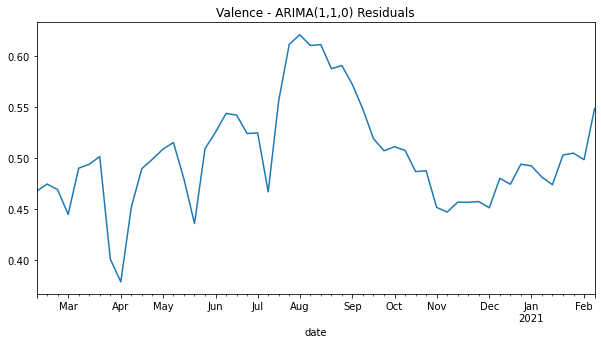

In [41]:
# RMSE 
train_rmse_valence_110 = mean_squared_error(train_valence[1::], preds_train_valence_arima_110)**0.5
print(f'Train RMSE - ARIMA(1,1,0): {train_rmse_valence_110}')

test_rmse_valence_110 = mean_squared_error(test_valence, preds_test_valence_arima_110)**0.5
print(f'Test RMSE - ARIMA(1,1,0): {test_rmse_valence_110}')

resids_valence_110 = test_valence - preds_test_valence_arima_110

resids_valence_110.plot(figsize=(10,5))
plt.title("Valence - ARIMA(1,1,0) Residuals");

In [75]:
output = model_valence_fit_110.forecast(10)
output

(array([0.46556763, 0.47151774, 0.47551923, 0.47821027, 0.48002002,
        0.48123709, 0.48205558, 0.48260602, 0.4829762 , 0.48322514]),
 array([0.03262237, 0.03931324, 0.04199063, 0.04314699, 0.04365992,
        0.04388994, 0.04399357, 0.04404036, 0.0440615 , 0.04407106]),
 array([[0.40162896, 0.52950631],
        [0.3944652 , 0.54857028],
        [0.39321912, 0.55781935],
        [0.39364372, 0.56277683],
        [0.39444814, 0.5655919 ],
        [0.3952144 , 0.56725978],
        [0.39582977, 0.56828139],
        [0.39628851, 0.56892354],
        [0.39661724, 0.56933516],
        [0.39684745, 0.56960284]]))

In [44]:
model_valence_fit_110.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.valence   No. Observations:                  159
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 312.608
Method:                       css-mle   S.D. of innovations              0.034
Date:                Mon, 15 Feb 2021   AIC                           -619.216
Time:                        18:02:00   BIC                           -610.009
Sample:                    01-22-2017   HQIC                          -615.477
                         - 02-02-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.002      0.176      0.860      -0.004       0.004
ar.L1.D.valence    -0.2919      0.076     -3.864      0.000      -0.440      -0.144
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4255           +0.0000j            3.4255            0.5000
-----------------------------------------------------------------------------
"""

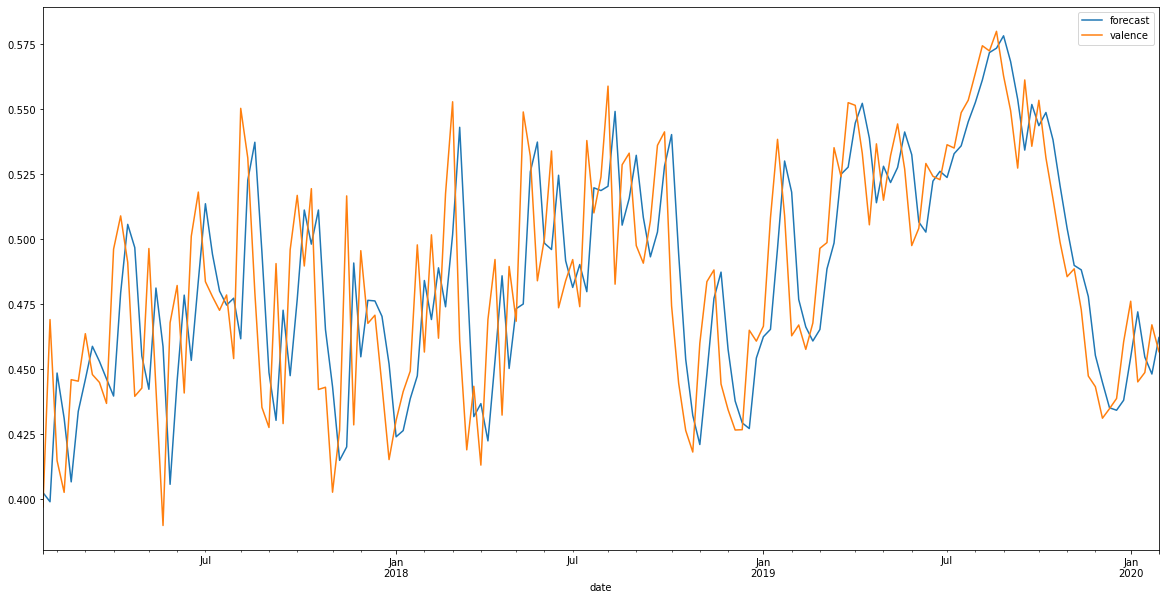

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
fig = model_valence_fit_110.plot_predict(dynamic=False, ax=ax)
plt.show()

### ACF & PACF Plots to Help Choose Best `p` and `q` parameters 

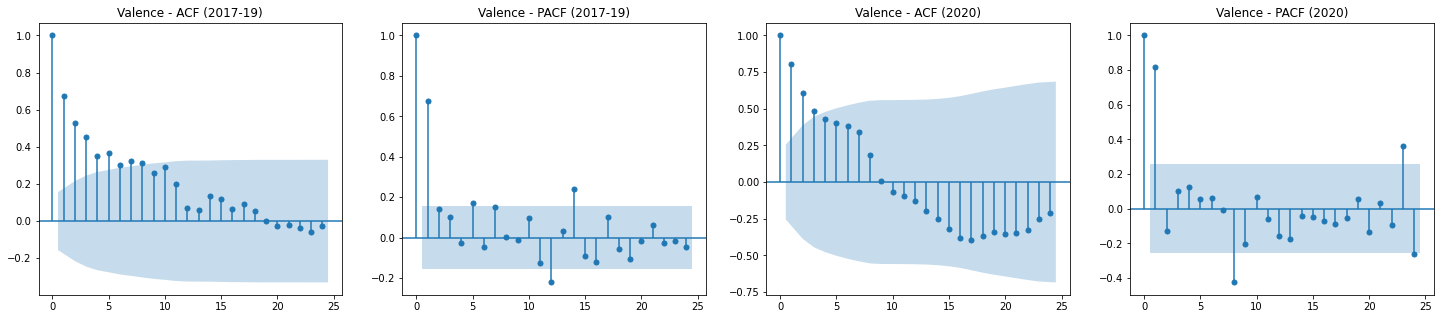

In [81]:
fig,ax = plt.subplots(1, 4, figsize=(25,5))
plot_acf(rw_italy_17_19['valence'], lags=24, title='Valence - ACF (2017-19)', ax=ax[0])
plot_pacf(rw_italy_17_19['valence'], lags=24, title='Valence - PACF (2017-19)', ax=ax[1])
plot_acf(rw_italy_20['valence'], lags=24, title='Valence - ACF (2020)', ax=ax[2])
plot_pacf(rw_italy_20['valence'], lags=24, title='Valence - PACF (2020)', ax=ax[3]) ;

#### Once-differenced `ACF` and `PACF` plots 

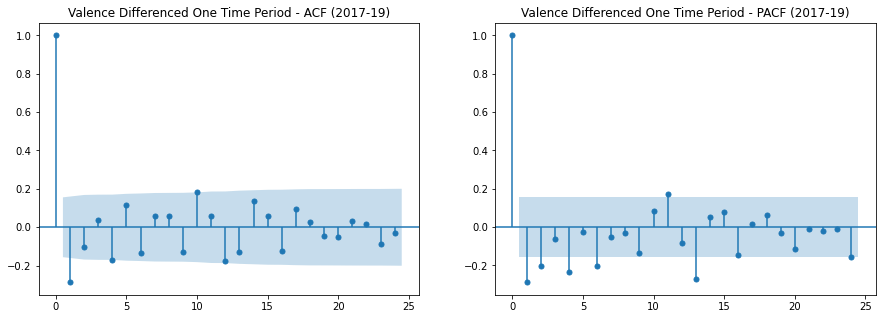

In [82]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(lag_df['valence_once_differenced'], lags=24, title='Valence Differenced One Time Period - ACF (2017-19)', ax=ax[0])
plot_pacf(lag_df['valence_once_differenced'], lags=24, title='Valence Differenced One Time Period - PACF (2017-19)', ax=ax[1]) ;

#### `ACF` and `PACF` plots for entire time period


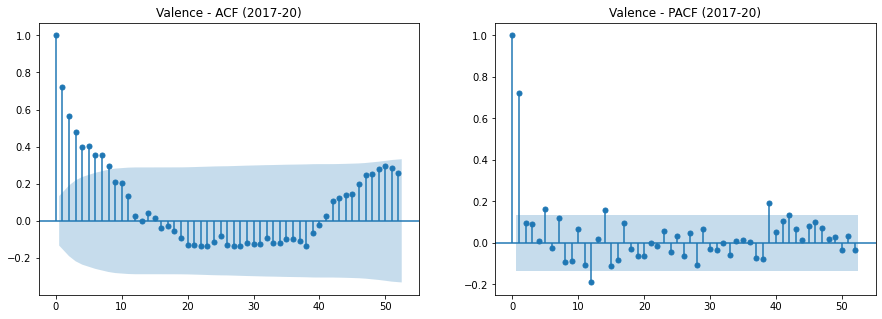

In [83]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(alltime_rw_italy['valence'], lags=52, title='Valence - ACF (2017-20)', ax=ax[0])
plot_pacf(alltime_rw_italy['valence'], lags=52, title='Valence - PACF (2017-20)', ax=ax[1]) ;

### _ARIMA(2,1,0)_

In [86]:
len(alltime_rw_italy['valence'])

train_valence = alltime_rw_italy['valence'][0:162]
test_valence = alltime_rw_italy['valence'][162:]

**I think the problem here is that I need to take differenced data..... if d=1, then I need to use the difference?**

In [87]:
model_valence_210 = ARIMA(train_valence, order=(2,1,0))

model_valence_fit_210 = model_valence_210.fit()

preds_train_valence_arima_210 = model_valence_fit_210.predict(start=train_valence.index[1], end=train_valence.index[-1])

preds_test_valence_arima_210 = model_valence_fit_210.predict(start=test_valence.index[0], end=test_valence.index[-1])

In [88]:
train_valence

date
2017-01-01    0.466054
2017-01-08    0.390494
2017-01-15    0.402156
2017-01-22    0.396994
2017-01-29    0.469083
                ...   
2020-01-05    0.476149
2020-01-12    0.445104
2020-01-19    0.448707
2020-01-26    0.467073
2020-02-02    0.456720
Freq: W-SUN, Name: valence, Length: 162, dtype: float64

In [89]:
preds_train_valence_arima_210

date
2017-01-08    0.000112
2017-01-15    0.022508
2017-01-22    0.012262
2017-01-29   -0.000479
2017-02-05   -0.024644
                ...   
2020-01-05   -0.008508
2020-01-12   -0.010145
2020-01-19    0.007974
2020-01-26    0.005570
2020-02-02   -0.007206
Freq: W-SUN, Length: 161, dtype: float64

Train RMSE - ARIMA(2,1,0): 0.4866982138678163
Test RMSE - ARIMA(2,1,0): 0.505335547558153


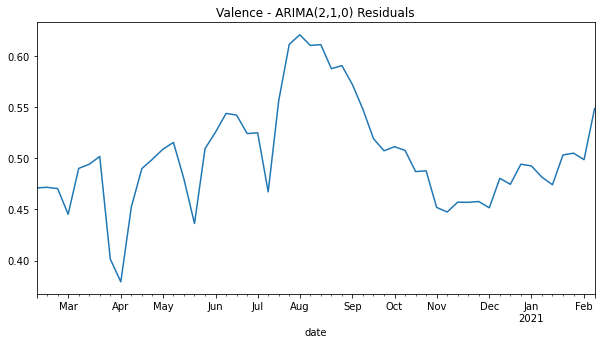

In [90]:
# evaluating the ARIMA(2,1,2) model 

# RMSE 
train_rmse_valence = mean_squared_error(train_valence[1::], preds_train_valence_arima_210)**0.5
print(f'Train RMSE - ARIMA(2,1,0): {train_rmse_valence}')

test_rmse_valence = mean_squared_error(test_valence, preds_test_valence_arima_210)**0.5
print(f'Test RMSE - ARIMA(2,1,0): {test_rmse_valence}')

resids_valence_210 = test_valence - preds_test_valence_arima_210

resids_valence_210.plot(figsize=(10,5))
plt.title("Valence - ARIMA(2,1,0) Residuals");

<AxesSubplot:xlabel='date'>

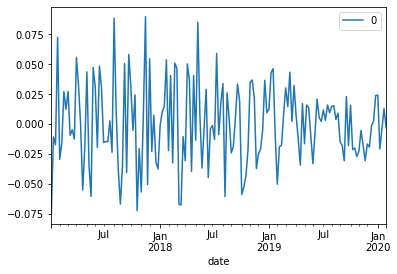

In [91]:
# from video https://www.youtube.com/watch?v=bqvZL8Ww3aA&ab_channel=DataScienceTutorials
residuals_df = pd.DataFrame(model_valence_fit_210.resid)
residuals_df.plot()

<AxesSubplot:ylabel='Density'>

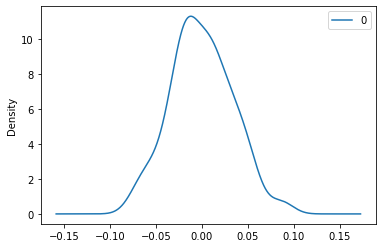

In [92]:
residuals_df.plot(kind='kde')

In [93]:
residuals_df.describe()

,0
count,161.000000
mean,-0.000225
std,0.033521
min,-0.075672
25%,-0.021001
50%,-0.001756
75%,0.022908
max,0.089826


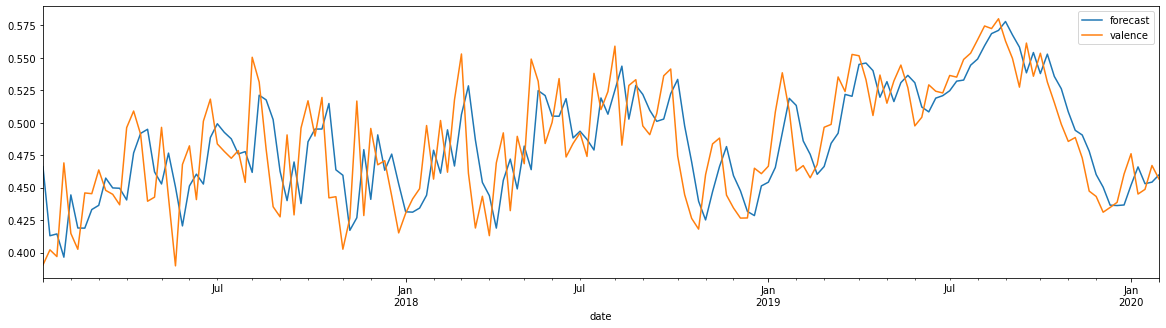

In [94]:
fig, ax = plt.subplots(figsize=(20,5))
fig = model_valence_fit_210.plot_predict(dynamic=False, ax=ax)
plt.show()

In [95]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
%matplotlib inline

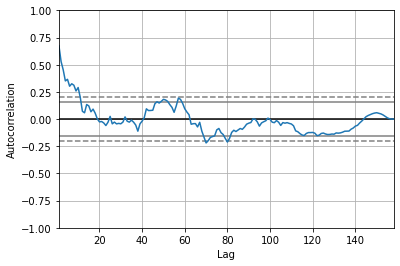

In [96]:
autocorrelation_plot(rw_italy_17_19['valence']) ; 

## More ARIMA models to compare

In [97]:
seven_features = ['danceability', 'energy',  'loudness', 'mode', 'acousticness', 'valence', 'tempo']

#### Gridsearch

In [98]:
model_valence_fit_110.aic

-642.6351957621176

In [99]:
model_valence_fit_210.aic

-629.9635240794992

In [101]:
# starting with large start AIC
best_aic = 99 * (10 * 16)
# creating variables to store best values ofd p and q 
best_p = 0
best_q = 0 

# use nested for loop to iterate over values of p and q
for p in range(6):
    
    for q in range(6):
        
        # insert try and and except statements
        try: 
            
            # fitting on ARIME(p, 1, q) model 
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # instantiate ARIMA model
            arima = ARIMA(train_valence, order=(p,1,q))
            
            # fit ARIMA model 
            model = arima.fit()
            
            # print out AIC for ARIMA(p, 1, q) model 
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            
            # Is this current model's AIC better than the OF best_aic? 
            if model.aic < best_aic:
                # we want aic to be lower so we are setting a high aic and hoping for something lower 
                
                # if it is, we overwrite the best_aic, best_p, and best_q
                best_aic = model.aic
                best_p = p 
                best_q = q
                
        except:
            pass 
        
print()
print()
print('MODEL FINISHED!')
print(f'The model for valence that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'The model has an aIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: -612.0025984653842
Attempting to fit ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: -634.2300847908593
Attempting to fit ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: -638.8223287221706
Attempting to fit ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: -637.1007776881372
Attempting to fit ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: -638.2794981877664
Attempting to fit ARIMA(0, 1, 5)
The AIC for ARIMA(0,1,5) is: -637.3993296127903
Attempting to fit ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: -624.4473246113482
Attempting to fit ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: -639.6669987144687
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting to fit ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: -629.9635240794992
Attempting to fit ARIMA(2, 1, 1)
The AIC for ARIMA(2,1,1) is: -637.6862577069514
Attempting to fit ARIMA(2, 1, 2)
Attempting to fit ARIMA(2

In [172]:
arima_dict = {
    'audio_feature':[],
    'AIC':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'ARIMA_model':[]
}

def find_p_and_q(df, feature, n=6):
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

    arima_dict['audio_feature'].append(feature)
    arima_dict['AIC'].append(best_aic)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')

    print()
    print(f'{feature.capitalize()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

**_Does AIC not look at test data?_** 

In [157]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in seven_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(alltime_rw_italy[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,energy,0
2,loudness,0
3,mode,1
4,acousticness,0
5,valence,0
6,tempo,0


In [158]:
# find_p_and_q(alltime_rw_italy, 'valence', n=6, d=1)

In [173]:
for feature in seven_features:
    find_p_and_q(alltime_rw_italy, feature)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -725.8837710601316
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -741.6315380820415
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -741.0303860542913
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -740.5524780247699
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -739.7901121166813
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -737.8819998993706
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -737.8870828958725
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -742.5043022824921
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -746.7977296013453
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting

In [174]:
arima_param_df = pd.DataFrame(arima_dict)
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,ARIMA_model
0,danceability,-746.797730,1,1,2,"ARIMA(1,1,2)"
1,energy,-712.406093,0,5,2,"ARIMA(5,0,2)"
2,loudness,229.336946,0,5,5,"ARIMA(5,0,5)"
3,mode,-446.531723,1,4,3,"ARIMA(4,1,3)"
4,acousticness,-619.986170,0,3,2,"ARIMA(3,0,2)"
5,valence,-647.409633,0,2,2,"ARIMA(2,0,2)"
6,tempo,796.904884,0,0,5,"ARIMA(0,0,5)"


In [ ]:
rmse_dict = {
    'audio_feature':[],
    'AIC':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'ARIMA_model':[]
}
    
}

In [ ]:
arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'train_rmse'] = train_rmse 

In [212]:
def arima_predict_plot(df, feature, order=(1,0,0), d=0, title='title'):
    
    train = df[feature][0:162]
    test = df[feature][162:]
    
    model = ARIMA(train, order=order)
    
    arima = model.fit()
    
    preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1])
    preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1])
    
    # RMSE 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE - ARIMA({order}): {test_rmse}')

    residuals = test - preds_test
    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'test_rmse'] = test_rmse
    
    # Plot data.
    plt.figure(figsize=(15,5))

    # Plot training data.
    plt.plot(train, color = 'blue')
#     plt.plot(train.index, pd.DataFrame(train), color = 'blue')

    # Plot testing data.
    plt.plot(test, color = 'orange')
#     plt.plot(test.index, pd.DataFrame(test), color = 'orange')
    

    # Plot predicted test values.
    plt.plot(test.index, preds_test, color = 'green')
    
    plt.title(title, fontsize=16)
    plt.show();

    return arima, residuals 

Acousticness train RMSE - ARIMA((3, 0, 2)): 0.03432241363762001
Acousticness test RMSE - ARIMA((3, 0, 2)): 0.07092032798729309


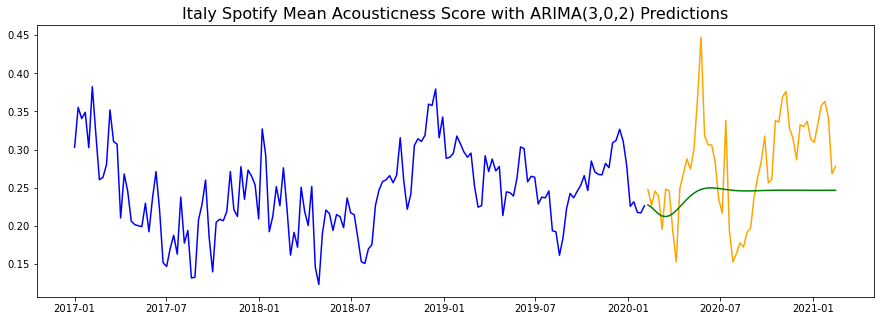

In [213]:
acousticness_302, acousticness_302_resids = arima_predict_plot(alltime_rw_italy, 'acousticness', order=(3,0,2), d=0, title='Italy Spotify Mean Acousticness Score with ARIMA(3,0,2) Predictions')

In [214]:
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,ARIMA_model,train_rmse,test_rmse
0,danceability,-746.797730,1,1,2,"ARIMA(1,1,2)",NaN,NaN
1,energy,-712.406093,0,5,2,"ARIMA(5,0,2)",NaN,NaN
2,loudness,229.336946,0,5,5,"ARIMA(5,0,5)",NaN,NaN
3,mode,-446.531723,1,4,3,"ARIMA(4,1,3)",NaN,NaN
4,acousticness,-619.986170,0,3,2,"ARIMA(3,0,2)",0.034322,0.07092
5,valence,-647.409633,0,2,2,"ARIMA(2,0,2)",NaN,NaN
6,tempo,796.904884,0,0,5,"ARIMA(0,0,5)",NaN,NaN
